In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

## 추천프로그램

데이터를 다집어넣고 돌리면 램터져서 2015년 데이터만 가지고 시뮬레이션 돌림

In [3]:
# 데이터 불러오기
import pandas as pd
total = pd.read_csv('/content/drive/MyDrive/2차프로젝트 공유폴더/프로젝트데이터셋/total_final.csv',index_col=0)

In [4]:
total['대분류']=total['대분류'].replace(['가공식품','신선식품'],'식품')
total['대분류']=total['대분류'].replace(['의류','패션잡화'],'의류')
total['대분류']=total['대분류'].replace(['전문스포츠/레저','교육/문화용품'],'취미')
total['대분류']=total['대분류'].replace(['디지털/가전','가구/인테리어'],'주거')
total['대분류'].unique()

array(['일상용품', '식품', '취미', '의류', '주거', '음식점', '의약품/의료기기', '기타'],
      dtype=object)

In [5]:
total1=total[total['대분류'].isin(['식품','일상용품'])].reset_index(drop=True)

In [ ]:
# 필요한 데이터 그룹화
df = total1.groupby(['고객번호','소분류코드','소분류명','구매일자'])['영수증번호'].nunique().reset_index()

In [6]:
# 구매감소모델 돌린결과
pred = pd.read_csv('/content/drive/MyDrive/2차프로젝트 공유폴더/프로젝트데이터셋/cluster.csv',index_col=0)
pred

,고객번호,성별,연령대,Recency_R,구매횟수_F,구매금액_M,연평균성장률,식품구매비중,식품_방문지수,고가_방문지수,유형,실루엣계수
0,1,0,6,1,5,5,-0.259681,0.148453,0.6,-0.2,2,0.335040
1,2,0,6,2,4,5,-0.033423,0.153350,-2.4,0.4,2,0.148630
2,7,1,6,2,2,5,-1.763857,0.111419,-1.4,0.0,2,0.185036
3,10,1,6,3,5,3,-0.259288,0.694089,0.0,0.6,4,0.216958
4,11,0,6,4,3,5,-1.869347,0.127777,0.4,-0.2,2,0.238485
...,...,...,...,...,...,...,...,...,...,...,...,...
9019,19314,1,4,1,3,5,-1.194635,0.041125,-0.2,0.4,2,0.392426
9020,19325,1,4,2,3,3,-0.906757,0.352661,2.8,1.6,0,0.198347
9021,19327,0,5,1,5,1,-0.953285,0.878719,-2.2,1.6,4,0.123898
9022,19333,1,2,2,4,1,-1.377282,0.919496,-1.0,1.2,4,0.201445


In [ ]:
# 감소고객 고객번호
cus_id=pred.고객번호.tolist()

In [ ]:
# 감소고객을 대상으로 선정
df=df[df['고객번호'].isin(cus_id)]
df

,고객번호,소분류코드,소분류명,구매일자,영수증번호
0,1,A010101,위생세제,20140130,1
1,1,A010101,위생세제,20140228,1
2,1,A010101,위생세제,20140919,1
3,1,A010101,위생세제,20150327,1
4,1,A010101,위생세제,20151130,1
...,...,...,...,...,...
24922630,19334,C170206,종량제봉투,20151126,1
24922631,19334,C170427,여성헤어액세서리,20141108,1
24922632,19334,C170646,유아서적,20141112,1
24922633,19334,C170646,유아서적,20151112,1


In [ ]:
# 2015년 데이터만 추출
df=df.query('구매일자 > 20141231 and 구매일자 <20151232')
df

,고객번호,소분류코드,소분류명,구매일자,영수증번호
3,1,A010101,위생세제,20150327,1
4,1,A010101,위생세제,20151130,1
7,1,A010103,뷰티상품,20151230,1
8,1,A010104,일용잡화,20150327,1
11,1,A010106,단기행사,20150426,1
...,...,...,...,...,...
24922628,19334,C170206,종량제봉투,20151112,1
24922629,19334,C170206,종량제봉투,20151115,1
24922630,19334,C170206,종량제봉투,20151126,1
24922633,19334,C170646,유아서적,20151112,1


In [ ]:
df.reset_index(inplace=True,drop=True)

In [ ]:
# 11월 이전 이후로 데이터 나누기
df_year_round = df[df['구매일자'] < 20151001]
df_year_end = df[df['구매일자'] > 20150930]

In [ ]:
# 점수를 매기기위해 그룹화
uir_df=df_year_round.groupby(['고객번호','소분류명'])['영수증번호'].nunique().reset_index()
uir_df

,고객번호,소분류명,영수증번호
0,7,L/C 아웃도어,1
1,7,L/C골프의류,1
2,7,Local상추,1
3,7,N/B골프의류,1
4,7,NB구두,1
...,...,...,...
859644,19333,한식델리,2
859645,19333,햄,1
859646,19333,헬스건강,1
859647,19333,홈아이스,1


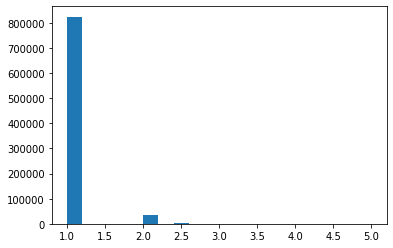

In [ ]:
# 정규화후 1~5 사이의 점수로 변환한다.
import numpy as np
uir_df['점수'] = uir_df['영수증번호'].apply(lambda x: np.log10(x)+1)
uir_df['점수'] = ((uir_df['점수'] - uir_df['점수'].min()) / 
                    (uir_df['점수'].max() - uir_df['점수'].min()) * 4) + 1
uir_df['점수'].hist(bins=20, grid=False)

In [ ]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626455 sha256=e4612005878e9e5614817b82beb8a1d57003d8a8b4c1e5344e5e6021a4e04dc1
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [ ]:
import time
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

In [ ]:
# 필요한 데이터 그룹화
#df = total.groupby(['고객번호','소분류코드','소분류명','구매일자'])['영수증번호'].nunique().reset_index()

In [ ]:
# 2015년 데이터만 추출
#df=df.query('구매일자 > 20141231 and 구매일자 <20151232')
#df

,고객번호,소분류코드,소분류명,구매일자,영수증번호
3,1,A010101,위생세제,20150327,1
4,1,A010101,위생세제,20151130,1
7,1,A010103,뷰티상품,20151230,1
8,1,A010104,일용잡화,20150327,1
11,1,A010106,단기행사,20150426,1
...,...,...,...,...,...
27742047,19383,D080204,아이섀도우,20151204,1
27742048,19383,D080204,아이섀도우,20151206,2
27742049,19383,D080205,메이크업세트,20150815,1
27742050,19383,D080302,립글로즈/틴트,20151206,2


In [ ]:
# 11월 이전 이후로 데이터 나누기
#df_year_round = df[df['구매일자'] < 20151101]
#f_year_end = df[df['구매일자'] > 20151031]

In [ ]:
#df11=df_year_round.groupby(['고객번호','소분류명'])['영수증번호'].nunique().reset_index()
#import numpy as np
#df11['점수'] = df11['영수증번호'].apply(lambda x: np.log10(x)+1)
#df11['점수'] = ((df11['점수'] - df11['점수'].min()) / 
                    #(df11['점수'].max() - df11['점수'].min()) * 4) + 1
#df11

,고객번호,소분류명,영수증번호,점수
0,1,Bag&Bag,1,1.00000
1,1,L.B,1,1.00000
2,1,L/C 아웃도어,1,1.00000
3,1,N.B,1,1.00000
4,1,VIC마켓피자,2,1.95925
...,...,...,...,...
3686159,19383,풋케어,1,1.00000
3686160,19383,하드캔디,1,1.00000
3686161,19383,핸드로션/크림,1,1.00000
3686162,19383,헤어에센스,1,1.00000


In [ ]:
#df11['점수'].max()

5.0

In [ ]:
# 모델 RMSE 평가
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df11[['고객번호', '소분류명', '점수']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델학습
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=200)
model.fit(train_data)
train_end = time.time()

predictions = model.test(test_data)
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

RMSE of test dataset in SVD model:
RMSE: 0.2020


0.20202745609423575

In [ ]:
# 2015년 11월 이전 데이터를 trainset 
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(uir_df[['고객번호', '소분류명', '점수']], reader)
train_data = data.build_full_trainset()

# SVD 모델학습
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=200)
model.fit(train_data)
train_end = time.time()


In [ ]:
# 이전에 구매하지 않았던 상품
test_data = train_data.build_anti_testset()
target_user_predictions = model.test(test_data)

In [ ]:
# 이전에 구매하지 않았던 상품 딕셔너리
new_order_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in new_order_prediction_dict:
        if stock_code in new_order_prediction_dict[customer_id]:
            pass
        else:
            new_order_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        new_order_prediction_dict[customer_id] = {}
        new_order_prediction_dict[customer_id][stock_code] = predicted_rating
                
print(str(new_order_prediction_dict)[:300] + "...")

{7: {'NB 여화': 1.0535863605832456, 'PB 계란': 1, 'PB바나나': 1.005150711640928, '가 방': 1, '가자미': 1, '가지': 1, '간장': 1, '감자스낵': 1.0621423180748613, '건강식품(홍삼)': 1.056082058504054, '건과': 1.013114916555096, '건다시마': 1, '건생선': 1.0073957107812321, '걸레/청소포': 1, '고구마': 1, '공병/공박스': 1.020817219158677, '과실주/담금주': 1, ...


In [ ]:
# 이전에 구매했었던 상품
test_data = train_data.build_testset()
target_user_predictions = model.test(test_data)

In [ ]:
# 이전에 구매했었던 상품 딕셔너리 
reorder_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in reorder_prediction_dict:
        if stock_code in reorder_prediction_dict[customer_id]:
            pass
        else:
            reorder_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        reorder_prediction_dict[customer_id] = {}
        reorder_prediction_dict[customer_id][stock_code] = predicted_rating
        
print(str(reorder_prediction_dict)[:300] + "...")

{7: {'L/C 아웃도어': 1, 'L/C골프의류': 1.3207840814898657, 'Local상추': 1, 'N/B골프의류': 1.1079894433142172, 'NB구두': 1.0244482734212492, 'NB돼지고기': 1.0304596887531814, 'OA용품': 1.0039573771280288, '가공우유': 1.001946662501806, '가정보수용품': 1, '가정용화장지': 1.0083147011375273, '간식용소시지': 1.001916002125409, '간이의자': 1, '감': 1.0...


In [ ]:
# 두 딕셔너리를 하나로 통합
total_prediction_dict = {}


for customer_id in new_order_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in new_order_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            

for customer_id in reorder_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in reorder_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            
print(str(total_prediction_dict)[:300] + "...")

{7: {'NB 여화': 1.0535863605832456, 'PB 계란': 1, 'PB바나나': 1.005150711640928, '가 방': 1, '가자미': 1, '가지': 1, '간장': 1, '감자스낵': 1.0621423180748613, '건강식품(홍삼)': 1.056082058504054, '건과': 1.013114916555096, '건다시마': 1, '건생선': 1.0073957107812321, '걸레/청소포': 1, '고구마': 1, '공병/공박스': 1.020817219158677, '과실주/담금주': 1, ...


In [ ]:
# 11월 이후의 데이터 -> 테스트로 활용
simulation_test_df = df_year_end.groupby('고객번호')['소분류명'].apply(set).reset_index()
simulation_test_df.columns = ['cus_id', 'RealOrdered']
simulation_test_df.head()

,cus_id,RealOrdered
0,7,"{에스닉푸드, 브랑제리, 단무지, 영플라자(기타), 우육, 한식델리, 두부류, 멸치..."
1,14,"{일반계란, 참기름, 브랑제리, 냉장면류, 즉석밥, 영플라자(기타), 감자스낵, 호..."
2,74,"{에스닉푸드, 주방잡화, 떡볶이, 케익류, 감자스낵, 네셔널, TGIF, 캐릭터 여..."
3,123,"{친환경열매채소, 느타리버섯, 진심한우, 메추리알, 칠레블루베리, 차별화계란, 대봉..."
4,138,"{주류, 프리미엄스낵, 디스커버리, 주방잡화, 훈제/로스트, 곤약, 한식델리, 미국..."


In [ ]:
#시뮬레이션 결과 추가
def add_predicted_stock_set(customer_id, prediction_dict):
    if customer_id in prediction_dict:
        predicted_stock_dict = prediction_dict[customer_id]
        sorted_stocks = sorted(predicted_stock_dict, key=lambda x : predicted_stock_dict[x], reverse=True)
        return sorted_stocks
    else:
        return None

# 상품 추천 시뮬레이션 결과를 추가
simulation_test_df['PredictedOrder(New)'] = simulation_test_df['cus_id']. \
                                            apply(lambda x: add_predicted_stock_set(x, new_order_prediction_dict))
simulation_test_df['PredictedOrder(Reorder)'] = simulation_test_df['cus_id']. \
                                            apply(lambda x: add_predicted_stock_set(x, reorder_prediction_dict))
simulation_test_df['PredictedOrder(Total)'] = simulation_test_df['cus_id']. \
                                            apply(lambda x: add_predicted_stock_set(x, total_prediction_dict))
simulation_test_df.head()                            

,cus_id,RealOrdered,PredictedOrder(New),PredictedOrder(Reorder),PredictedOrder(Total)
0,7,"{에스닉푸드, 브랑제리, 단무지, 영플라자(기타), 우육, 한식델리, 두부류, 멸치...","[색조 화장품, 바버 상품군, 유원시설, 커피용품, 컨템포러리, 스넥(부대), 헤지...","[기초 화장품, 수입식품, 일식델리, 수입주방, 직수입 골프의류, 청과, 서양델리,...","[기초 화장품, 색조 화장품, 수입식품, 바버 상품군, 일식델리, 유원시설, 수입주..."
1,14,"{일반계란, 참기름, 브랑제리, 냉장면류, 즉석밥, 영플라자(기타), 감자스낵, 호...","[커피용품, 바버 상품군, 유원시설, 수입주방, 생필(부대), 헤지스골프, 스포츠의...","[직수입 골프의류, 수입식품, 청과, 기초 화장품, L/C 아웃도어, 유제품, 일식...","[직수입 골프의류, 수입식품, 커피용품, 청과, 바버 상품군, 유원시설, 기초 화장..."
2,74,"{에스닉푸드, 주방잡화, 떡볶이, 케익류, 감자스낵, 네셔널, TGIF, 캐릭터 여...","[L/C골프의류, 유원시설, 직수입 골프의류, 생필(부대), 영플라자(기타), N/...","[기초 화장품, 수입식품, 수입주방, 유기농채소, 캐릭터 여화, 욕실용품, 제과제빵...","[L/C골프의류, 유원시설, 기초 화장품, 직수입 골프의류, 생필(부대), 영플라자..."
3,123,"{친환경열매채소, 느타리버섯, 진심한우, 메추리알, 칠레블루베리, 차별화계란, 대봉...","[L/C 아웃도어, 유원시설, 커피용품, 바버 상품군, 남성용클렌저, 헤지스골프, ...","[기초 화장품, 다이소, 일반화장품, 일반스낵, 감자스낵, 여성화장품, 유아브랜드,...","[L/C 아웃도어, 유원시설, 커피용품, 바버 상품군, 기초 화장품, 남성용클렌저,..."
4,138,"{주류, 프리미엄스낵, 디스커버리, 주방잡화, 훈제/로스트, 곤약, 한식델리, 미국...","[커피용품, 바버 상품군, 나이키골프, 시리즈, 수영복, 수입도자기, 에어컨, PA...","[L/C 아웃도어, 스포츠의류, 일식델리, 스포츠화, 수입주방, 직수입 골프의류, ...","[L/C 아웃도어, 스포츠의류, 일식델리, 커피용품, 스포츠화, 바버 상품군, 나이..."


In [ ]:
# 구매 예측의 상위 k개의 recall(재현율)
def calculate_recall(real_order, predicted_order, k):
    # 만약 추천 대상 상품이 없다면, 11월 이후에 상품을 처음 구매하는 고객
    if predicted_order is None:
        return None
    
    # SVD 모델에서 현재 유저의 Rating이 높은 상위 k개의 상품을 "구매 할 것으로 예측"
    predicted = predicted_order[:k]
    true_positive = 0
    for stock_code in predicted:
        if stock_code in real_order:
            true_positive += 1
    
    # 예측한 상품 중, 실제로 유저가 구매한 상품의 비율 계산
    recall = true_positive / len(predicted)
    return recall

In [ ]:
# 시뮬레이션 대상 유저에게 상품을 추천해준 결과를 평가
simulation_test_df['top_k_recall(Reorder)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Reorder)'], 
                                                                                 5), axis=1)
simulation_test_df['top_k_recall(New)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(New)'], 
                                                                                 5), axis=1)
simulation_test_df['top_k_recall(Total)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Total)'], 
                                                                                 5), axis=1)

In [ ]:
# 평가 결과
print(simulation_test_df['top_k_recall(Reorder)'].mean())
print(simulation_test_df['top_k_recall(New)'].mean())
print(simulation_test_df['top_k_recall(Total)'].mean())

0.4817548746518106
0.012186629526462395
0.1634401114206128


## 재주문 평균재현도 47%, 이전에 구매하지 않은 상품 1%


In [ ]:
simulation_test_df

,cus_id,RealOrdered,PredictedOrder(New),PredictedOrder(Reorder),PredictedOrder(Total),top_k_recall(Reorder),top_k_recall(New),top_k_recall(Total)
0,7,"{에스닉푸드, 브랑제리, 단무지, 영플라자(기타), 우육, 한식델리, 두부류, 멸치...","[색조 화장품, 바버 상품군, 유원시설, 커피용품, 컨템포러리, 스넥(부대), 헤지...","[기초 화장품, 수입식품, 일식델리, 수입주방, 직수입 골프의류, 청과, 서양델리,...","[기초 화장품, 색조 화장품, 수입식품, 바버 상품군, 일식델리, 유원시설, 수입주...",0.4,0.0,0.2
1,14,"{일반계란, 참기름, 브랑제리, 냉장면류, 즉석밥, 영플라자(기타), 감자스낵, 호...","[커피용품, 바버 상품군, 유원시설, 수입주방, 생필(부대), 헤지스골프, 스포츠의...","[직수입 골프의류, 수입식품, 청과, 기초 화장품, L/C 아웃도어, 유제품, 일식...","[직수입 골프의류, 수입식품, 커피용품, 청과, 바버 상품군, 유원시설, 기초 화장...",0.4,0.0,0.4
2,74,"{에스닉푸드, 주방잡화, 떡볶이, 케익류, 감자스낵, 네셔널, TGIF, 캐릭터 여...","[L/C골프의류, 유원시설, 직수입 골프의류, 생필(부대), 영플라자(기타), N/...","[기초 화장품, 수입식품, 수입주방, 유기농채소, 캐릭터 여화, 욕실용품, 제과제빵...","[L/C골프의류, 유원시설, 기초 화장품, 직수입 골프의류, 생필(부대), 영플라자...",0.8,0.0,0.2
3,123,"{친환경열매채소, 느타리버섯, 진심한우, 메추리알, 칠레블루베리, 차별화계란, 대봉...","[L/C 아웃도어, 유원시설, 커피용품, 바버 상품군, 남성용클렌저, 헤지스골프, ...","[기초 화장품, 다이소, 일반화장품, 일반스낵, 감자스낵, 여성화장품, 유아브랜드,...","[L/C 아웃도어, 유원시설, 커피용품, 바버 상품군, 기초 화장품, 남성용클렌저,...",0.6,0.0,0.0
4,138,"{주류, 프리미엄스낵, 디스커버리, 주방잡화, 훈제/로스트, 곤약, 한식델리, 미국...","[커피용품, 바버 상품군, 나이키골프, 시리즈, 수영복, 수입도자기, 에어컨, PA...","[L/C 아웃도어, 스포츠의류, 일식델리, 스포츠화, 수입주방, 직수입 골프의류, ...","[L/C 아웃도어, 스포츠의류, 일식델리, 커피용품, 스포츠화, 바버 상품군, 나이...",0.6,0.0,0.6
...,...,...,...,...,...,...,...,...
2867,19268,"{남성용스킨케어류, 헤어에센스, 캐릭터 여화, 커피음료, 밥류, 일반비타민, 건강보...","[정육세트, 유원시설, 남성용클렌저, 스넥(부대), 청과세트, 컨템포러리, 커피용품...","[일반스낵, 다이소, 커피음료, 냉장커피차음료, 국산맥주, 아이섀도우, 생수, 남성...","[정육세트, 유원시설, 남성용클렌저, 스넥(부대), 청과세트, 컨템포러리, 커피용품...",0.2,0.0,0.0
2868,19289,"{파리모기살충제, 냉장커피음료, 식빵, 소스, 케찹, NB돼지고기, 양배추, 즉석도...","[L/C 아웃도어, 커피용품, 바버 상품군, 색조 화장품, 유기농채소, 컨템포러리,...","[기초 화장품, 유원시설, 디저트류, 서양델리, 욕실용품, 종량제봉투, 일반화장품,...","[기초 화장품, L/C 아웃도어, 커피용품, 바버 상품군, 색조 화장품, 유기농채소...",0.0,0.0,0.0
2869,19293,"{하루견과, 소스, 식기세제, 호주산곡물비육, 연근, 건강미용차, 사이다, 냉장떡,...","[유기농채소, 유원시설, 직수입 골프의류, 기초 화장품, 커피용품, L/C 아웃도어...","[일반화장품, 여성화장품, 종량제봉투, 재사용봉투, 다이소, 중저가화장품기타, 여성...","[유기농채소, 유원시설, 직수입 골프의류, 기초 화장품, 커피용품, L/C 아웃도어...",0.8,0.0,0.0
2870,19304,"{에스닉푸드, 브랑제리, 주방잡화, 수입도자기, 우육, 식당가 레스토랑, 수입식품,...","[지방스넥(부대), 생필(부대), 유원시설, 수영복, 스넥(부대), 바버 상품군, ...","[기초 화장품, 유기농채소, 일식델리, 디저트류, 한식델리, 색조 화장품, 전문베이...","[기초 화장품, 지방스넥(부대), 유기농채소, 일식델리, 디저트류, 한식델리, 색조...",0.6,0.0,0.6


In [ ]:
# 추천 시뮬레이션 결과
k = 5
result_df = simulation_test_df[simulation_test_df['PredictedOrder(Reorder)'].notnull()]
result_df['PredictedOrder(Reorder)'] = result_df['PredictedOrder(Reorder)'].\
                                        apply(lambda x: x[:k])
result_df = result_df[['cus_id', 'RealOrdered', 'PredictedOrder(Reorder)', 'top_k_recall(Reorder)']]

result_df=result_df.rename({"cus_id":"고객번호","RealOrdered":"실제주문","PredictedOrder(Reorder)":"추천주문5개","top_k_recall(Reorder)":"재현도"},axis=1)

result_df.sample(5).head()

,고객번호,실제주문,추천주문5개,재현도
518,4122,"{안주류, 캐릭터 여화, 수입식품, 뷰티상품, 건생선, 건강식품(비타민), 색조 화...","[기초 화장품, 색조 화장품, 일식델리, 수입주방, 서양델리]",0.6
2350,14679,"{즉석밥, 훈제/로스트, 모장갑, 롤티슈, 사이다, 냉장떡, 미국청포도, 치킨, 감...","[얼음, 파우치/즉석음료, 일반스낵, 종량제봉투, 일반우유]",0.6
1114,7380,"{친환경양념채소, 냉장면류, 깻잎, 탄산수, 도어락, 표고버섯, 소스, 감자스낵, ...","[유기농채소, 청과, 일반화장품, 유제품, 일식델리]",0.4
1766,10683,"{헤지스골프, 건과일, 캐주얼화, 마시는요구르트, 기능성껌, 감자스낵, 굴비류, 일...","[기초 화장품, 수입주방, L/C 아웃도어, 색조 화장품, 스포츠의류]",0.0
413,3456,"{냉장면류, 느타리버섯, 컵, 소스, 한우규격, 유부, 냉동식사HMR, 덴탈식품, ...","[L/C 아웃도어, 생필(부대), 색조 화장품, 일반화장품, 종량제봉투]",0.4


In [ ]:
result_df[result_df['고객번호'] == 14322]['추천주문5개']

6964    [일반화장품, 재사용봉투, 다이소, 일반스낵, 커피음료]
Name: 추천주문5개, dtype: object

In [ ]:
simulation_test_df.columns

Index(['cus_id', 'RealOrdered', 'PredictedOrder(New)',
       'PredictedOrder(Reorder)', 'PredictedOrder(Total)',
       'top_k_recall(Reorder)', 'top_k_recall(New)', 'top_k_recall(Total)'],
      dtype='object')

In [ ]:
result_df.columns

Index(['고객번호', '실제주문', '추천주문5개', '재현도'], dtype='object')

## ㅇㅇ---------------------------------------------------------------------

In [ ]:
product = pd.read_csv('/content/drive/MyDrive/lmemdata/상품분류.txt',sep = ",",  engine='python', encoding = "cp949")

### 재구매 상품 추천해주는 함수

In [ ]:
def find_sim_cus(df,cus_id,top_n):
  df11=df.iloc[:,:10]
  df11.reset_index(inplace=True,drop=True)
  
  simil=cosine_similarity(df11.iloc[:,1:],df11.iloc[:,1:])
  sim_sorted_ind = simil.argsort()[:,::-1]


  user_id = df[df['고객번호']==cus_id]

  user_id_index = user_id.index.values
  similar_indexes = sim_sorted_ind[user_id_index,:(top_n)]

  #print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

In [ ]:
def get_unpurchase(df,product,userid,select):
  # 입력값으로 들어온 고객번호에 해당하는 고객이 구매한 모든 상품을 리스트로 생성
  buy = df[df['고객번호']==userid]['소분류명'].tolist()

  # 모든 상품을 리스트로 생성
  total_product = product['소분류명'].tolist()

  # 모든 상품의 소분류명중 구매한 소분류를 제외루 리스트로 생성
  unbuy = [product for product in total_product if product not in buy]

  # 그동안 많이구매한상품 best 5 와 장바구니 비교해서 추천
  top_5 = df[df['고객번호']==userid]
  top_5 = top_5.sort_values(by=['점수'],ascending=False).head()
  top_5 = top_5['소분류명'].tolist()
  top_5_set = set(top_5)
  select_set = set(select)
  recommend=top_5_set.difference(select_set)


  # 유사고객이 많이구매한상품 best 10
  result=find_sim_cus(predict2,userid,5)
  result=result[~result['고객번호'].isin([userid])]
  similar_cus=result['고객번호'].reset_index(drop=True)
  similar_customer=similar_cus.loc[1]
  similar_top_10 = df[df['고객번호']==similar_customer]
  similar_top_10 = similar_top_10.sort_values(by=['점수'],ascending=False).head(10)
  similar_top_10 = similar_top_10['소분류명'].tolist()
  similar_top_10_set = set(similar_top_10)

  # 그동안 많이구매한상품 best 10
  top_10 = df[df['고객번호']==userid]
  top_10 = top_10.sort_values(by=['점수'],ascending=False).head(10)
  top_10 = top_10['소분류명'].tolist()
  top_10_set = set(top_10)
  
  # 유사고객과 비교해서 구매하지 않은 상품
  recommend2 = similar_top_10_set.difference(top_10_set)

  


  print('구매한 상품수:',len(buy),'추천대상 상품수',len(unbuy),'전체 상품수',len(total_product))
  print()
  #print('구매한 상품:',buy)
  print('장바구니에 담은 상품',select)
  print()
  #print('구매기록이없는 상품:',unbuy)
  #print()
  #print('전체 상품:',total_product)
  #print()
  print('추천상품:',recommend)
  print()
  print('추천상품2:',recommend2)
  return result
unbuy_product = get_unpurchase(df=df2,product=product,userid=19307,select=['고추','일반두유','일반스낵'])

구매한 상품수: 305 추천대상 상품수 3848 전체 상품수 4386

장바구니에 담은 상품 ['고추', '일반두유', '일반스낵']

추천상품: {'냉장치킨족발류', '콘아이스크림', '즉석밥'}

추천상품2: {'일반란', '미곡류', '인스턴트커피', '펫가공유', '호주산목초비육', '일반화장품', '여성화장품', '종량제봉투', '냉장음료', '감자스낵'}


In [ ]:
df2=df.groupby(['고객번호','소분류명'])['영수증번호'].nunique().reset_index()
# 정규화후 1~5 사이의 점수로 변환한다.
import numpy as np
df2['점수'] = df2['영수증번호'].apply(lambda x: np.log10(x)+1)
df2['점수'] = ((df2['점수'] - df2['점수'].min()) / 
                    (df2['점수'].max() - df2['점수'].min()) * 4) + 1
df2

,고객번호,소분류명,영수증번호,점수
0,1,Bag&Bag,1,1.000000
1,1,L/C 아웃도어,1,1.000000
2,1,PB바나나,1,1.000000
3,1,VIC피자,1,1.000000
4,1,가공우유,1,1.000000
...,...,...,...,...
5368045,19383,하드캔디,2,1.910681
5368046,19383,핸드로션/크림,1,1.000000
5368047,19383,핸드워시/손세정제,1,1.000000
5368048,19383,헤어에센스,1,1.000000


In [ ]:
df3 = df2.groupby('고객번호')['소분류명'].apply(list).reset_index()
df3

,고객번호,소분류명
0,1,"[Bag&Bag, L/C 아웃도어, VIC피자, 가공우유, 가방, 간편과일, 감자스..."
1,2,"[L/C골프의류, N/B골프의류, 가방, 건강식품, 건강식품(비타민), 건과, 건생..."
2,7,"[N/B골프의류, 가공우유, 가정용화장지, 가지, 간식용소시지, 감자, 건전지, 건..."
3,8,"[L/C 아웃도어, 가공행사, 건강식품, 건강식품(비타민), 건강식품(홍삼), 건과..."
4,10,"[Local깻잎, Local부추, Local상추, Local시금치, NB돼지고기, ..."
...,...,...
8651,19307,"[가공우유, 가공조미료, 가지, 각티슈/미용티슈, 간장, 감, 감자, 감자스낵, 갓..."
8652,19314,"[PECK Restaurant, 건강식품(비타민), 건강식품(홍삼), 건과, 공병,..."
8653,19325,"[L/C골프의류, Local상추, 간식용소시지, 감자, 감자스낵, 고구마, 고추, ..."
8654,19327,"[가공우유, 각티슈/미용티슈, 간장, 건오징어, 건홍합, 고등어, 골뱅이통조림, 과..."


## 유사고객 찾기

In [11]:
predict = pd.read_csv('/content/drive/MyDrive/2차프로젝트 공유폴더/프로젝트데이터셋/prediction1.csv',index_col=0)

In [ ]:
predict2=predict.iloc[:,:10]
predict2.reset_index(inplace=True,drop=True)

In [ ]:
predict=predict.reset_index()

In [ ]:
predict2.reset_index(inplace=True,drop=True)

In [ ]:
predict2

,고객번호,성별,거주지역,연령대,멤버십유무,경쟁사이용,온라인유무,Recency_R,구매횟수_F,구매금액_M
0,1,0,1,6,0,3,0,1,5,5
1,2,0,2,6,0,3,0,2,4,5
2,7,1,1,6,0,1,1,2,2,5
3,10,1,1,6,0,0,0,3,5,3
4,11,0,2,6,1,1,0,4,3,5
...,...,...,...,...,...,...,...,...,...,...
9019,19314,1,1,4,1,0,0,1,3,5
9020,19325,1,12,4,0,0,0,2,3,3
9021,19327,0,1,5,1,0,0,1,5,1
9022,19333,1,0,2,1,0,1,2,4,1


In [ ]:
predict2=predict2[predict2['고객번호'].isin(cus_id)]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
simil=cosine_similarity(predict2.iloc[:,1:],predict2.iloc[:,1:])

In [ ]:
simil2=pd.DataFrame(simil)
simil2

,0,1,2,3,4,5,6,7,8,9,...,9014,9015,9016,9017,9018,9019,9020,9021,9022,9023
0,1.000000,0.984415,0.915047,0.902530,0.899786,0.930580,0.922292,0.908452,0.897345,0.845996,...,0.539499,0.554297,0.855066,0.918241,0.783357,0.911929,0.510385,0.856661,0.748341,0.672757
1,0.984415,1.000000,0.941606,0.905359,0.946291,0.922806,0.936894,0.946497,0.934059,0.886245,...,0.638017,0.636517,0.901589,0.947824,0.843504,0.912331,0.602334,0.828116,0.721205,0.740359
2,0.915047,0.941606,1.000000,0.897315,0.951786,0.932227,0.919801,0.980064,0.957768,0.959960,...,0.566200,0.541719,0.885841,0.853610,0.812693,0.939710,0.536420,0.764510,0.685680,0.594551
3,0.902530,0.905359,0.897315,1.000000,0.926731,0.981981,0.986600,0.904918,0.921364,0.853461,...,0.484643,0.606577,0.900181,0.875190,0.685793,0.892098,0.550309,0.937459,0.881917,0.601238
4,0.899786,0.946291,0.951786,0.926731,1.000000,0.921407,0.957664,0.980648,0.955533,0.909400,...,0.620110,0.668145,0.955792,0.882034,0.852624,0.922195,0.616553,0.808694,0.748705,0.679284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,0.911929,0.912331,0.939710,0.892098,0.922195,0.935414,0.902778,0.920976,0.950262,0.903540,...,0.550395,0.597552,0.870388,0.793988,0.776927,1.000000,0.553274,0.796296,0.745800,0.601113
9020,0.510385,0.602334,0.536420,0.550309,0.616553,0.548458,0.543214,0.534205,0.717835,0.635174,...,0.967297,0.973797,0.606770,0.646959,0.479070,0.553274,1.000000,0.523095,0.391159,0.922457
9021,0.856661,0.828116,0.764510,0.937459,0.808694,0.920566,0.888889,0.764878,0.816632,0.744092,...,0.442475,0.597552,0.754337,0.813838,0.503953,0.796296,0.523095,1.000000,0.874386,0.616141
9022,0.748341,0.721205,0.685680,0.881917,0.748705,0.866025,0.867956,0.672010,0.701068,0.565878,...,0.269771,0.515845,0.805823,0.744279,0.583212,0.745800,0.391159,0.874386,1.000000,0.480001


In [ ]:
def find_sim_cus(df,cus_id,top_n):
  
  simil=cosine_similarity(df.iloc[:,1:],df.iloc[:,1:])
  sim_sorted_ind = simil.argsort()[:,::-1]


  user_id = df[df['고객번호']==cus_id]

  user_id_index = user_id.index.values
  similar_indexes = sim_sorted_ind[user_id_index,:(top_n)]

  #print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

In [ ]:
sim_sorted_ind = simil.argsort()[:,::-1]

In [ ]:
result=find_sim_cus(predict2,sim_sorted_ind,1,5)

In [ ]:
similar_cus=result['고객번호'].reset_index(drop=True)
similar_customer=similar_cus.loc[1]

In [ ]:
similar_customer

559

In [ ]:
result=result[~result['고객번호'].isin([10])]

In [ ]:
similar_cus=result['고객번호'].reset_index(drop=True)
similar_customer=similar_cus.loc[0]

In [ ]:
similar_customer

15259

In [ ]:
result

,고객번호,성별,거주지역,연령대,멤버십유무,경쟁사이용,온라인유무,Recency_R,구매횟수_F,구매금액_M
0,1,0,1,6,0,3,0,1,5,5
271,559,0,1,6,0,3,0,1,4,5
5747,11966,0,1,5,0,3,0,1,4,5
1486,2916,0,1,5,0,3,0,1,5,4
124,268,1,1,6,0,3,0,1,5,5


In [7]:
total1

,대분류코드,중분류코드,소분류코드,중분류명,소분류명,대분류,영수증번호,고객번호,점포코드,구매일자,구매시간,구매금액,성별,연령대,거주지역,년도,분류,분기,제휴사
0,1,101,A010101,일용잡화,위생세제,일상용품,2757986,15148,10,20140920,20,1000,1,5,2.0,2014,저가,3,A
1,1,101,A010101,일용잡화,위생세제,일상용품,1878938,15148,10,20140505,19,15000,1,5,2.0,2014,저가,2,A
2,1,101,A010101,일용잡화,위생세제,일상용품,3436437,15148,10,20150102,16,9900,1,5,2.0,2015,저가,5,A
3,1,101,A010103,일용잡화,뷰티상품,일상용품,1385676,15148,10,20140215,17,7000,1,5,2.0,2014,저가,1,A
4,1,101,A010103,일용잡화,뷰티상품,일상용품,1547466,15148,10,20140315,19,21000,1,5,2.0,2014,중가,1,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25587852,8,802,D080204,아이메이크업,아이섀도우,일상용품,229784,18799,24,20150805,15,9900,1,2,1.0,2015,저가,7,D
25587853,8,803,D080301,립메이크업,립스틱/립라이너,일상용품,230365,18799,24,20151203,16,11200,1,2,1.0,2015,저가,8,D
25587854,8,803,D080302,립메이크업,립글로즈/틴트,일상용품,229653,18799,24,20150618,16,7200,1,2,1.0,2015,저가,6,D
25587855,8,803,D080302,립메이크업,립글로즈/틴트,일상용품,229670,18799,24,20150625,14,9000,1,2,1.0,2015,저가,6,D


In [12]:
predict=predict.reset_index()

In [13]:
predict=predict[predict['온라인유무']==1]

In [14]:
predict=predict[predict['Label']==0]

In [15]:
predict=predict['고객번호'].tolist()

In [16]:
total2=total1[total1['고객번호'].isin(predict)]

In [17]:
total2.reset_index(inplace=True,drop=True)
total2

,대분류코드,중분류코드,소분류코드,중분류명,소분류명,대분류,영수증번호,고객번호,점포코드,구매일자,구매시간,구매금액,성별,연령대,거주지역,년도,분류,분기,제휴사
0,1,101,A010101,일용잡화,위생세제,일상용품,2757988,2043,10,20140920,13,3950,1,5,2.0,2014,저가,3,A
1,1,101,A010101,일용잡화,위생세제,일상용품,2574375,2043,10,20140821,14,9400,1,5,2.0,2014,저가,3,A
2,1,101,A010101,일용잡화,위생세제,일상용품,1951719,2043,10,20140516,14,1000,1,5,2.0,2014,저가,2,A
3,1,101,A010101,일용잡화,위생세제,일상용품,2274939,2043,10,20140704,14,10600,1,5,2.0,2014,저가,3,A
4,1,101,A010101,일용잡화,위생세제,일상용품,2548153,2043,10,20140816,14,5000,1,5,2.0,2014,저가,3,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895435,17,1707,C170701,가정잡화,생활잡화균일가,일상용품,773311,8477,44,20150719,13,1000,1,3,12.0,2015,저가,7,C
3895436,17,1707,C170701,가정잡화,생활잡화균일가,일상용품,774134,8477,44,20150904,9,1500,1,3,12.0,2015,저가,7,C
3895437,17,1707,C170701,가정잡화,생활잡화균일가,일상용품,773081,8477,44,20150706,10,2000,1,3,12.0,2015,저가,7,C
3895438,17,1707,C170701,가정잡화,생활잡화균일가,일상용품,774555,8477,44,20150928,19,2000,1,3,12.0,2015,저가,7,C


In [18]:
total2['구매금액'].sum()

60015924435

In [19]:
len(total2['고객번호'].unique())

2873

In [20]:
60015924435/2873

20889636.07205012

In [ ]:
total1

,대분류코드,중분류코드,소분류코드,중분류명,소분류명,대분류,영수증번호,고객번호,점포코드,구매일자,구매시간,구매금액,성별,연령대,거주지역,년도,분류,분기,제휴사
0,1,101,A010101,일용잡화,위생세제,일상용품,2757986,15148,10,20140920,20,1000,1,5,2.0,2014,저가,3,A
1,1,101,A010101,일용잡화,위생세제,일상용품,1878938,15148,10,20140505,19,15000,1,5,2.0,2014,저가,2,A
2,1,101,A010101,일용잡화,위생세제,일상용품,3436437,15148,10,20150102,16,9900,1,5,2.0,2015,저가,5,A
3,1,101,A010103,일용잡화,뷰티상품,일상용품,1385676,15148,10,20140215,17,7000,1,5,2.0,2014,저가,1,A
4,1,101,A010103,일용잡화,뷰티상품,일상용품,1547466,15148,10,20140315,19,21000,1,5,2.0,2014,중가,1,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25587852,8,802,D080204,아이메이크업,아이섀도우,일상용품,229784,18799,24,20150805,15,9900,1,2,1.0,2015,저가,7,D
25587853,8,803,D080301,립메이크업,립스틱/립라이너,일상용품,230365,18799,24,20151203,16,11200,1,2,1.0,2015,저가,8,D
25587854,8,803,D080302,립메이크업,립글로즈/틴트,일상용품,229653,18799,24,20150618,16,7200,1,2,1.0,2015,저가,6,D
25587855,8,803,D080302,립메이크업,립글로즈/틴트,일상용품,229670,18799,24,20150625,14,9000,1,2,1.0,2015,저가,6,D


In [21]:
# 필요한 데이터 그룹화
df = total2.groupby(['고객번호','소분류코드','소분류명','구매일자'])['영수증번호'].nunique().reset_index()

In [22]:
df

,고객번호,소분류코드,소분류명,구매일자,영수증번호
0,7,A010101,위생세제,20151105,1
1,7,A010103,뷰티상품,20141201,1
2,7,A010201,우육,20141030,1
3,7,A010201,우육,20150114,1
4,7,A010201,우육,20150308,1
...,...,...,...,...,...
3808660,19333,D040109,쿠키,20150925,1
3808661,19333,D040201,생수,20150424,1
3808662,19333,D040201,생수,20151112,1
3808663,19333,D040209,기타기능성음료,20150123,1


추천 전체 16%

In [ ]:
total2

,대분류코드,중분류코드,소분류코드,중분류명,소분류명,대분류,영수증번호,고객번호,점포코드,구매일자,구매시간,구매금액,성별,연령대,거주지역,년도,분류,분기,제휴사
0,1,101,A010101,일용잡화,위생세제,일상용품,2757988,2043,10,20140920,13,3950,1,5,2.0,2014,저가,3,A
1,1,101,A010101,일용잡화,위생세제,일상용품,2574375,2043,10,20140821,14,9400,1,5,2.0,2014,저가,3,A
2,1,101,A010101,일용잡화,위생세제,일상용품,1951719,2043,10,20140516,14,1000,1,5,2.0,2014,저가,2,A
3,1,101,A010101,일용잡화,위생세제,일상용품,2274939,2043,10,20140704,14,10600,1,5,2.0,2014,저가,3,A
4,1,101,A010101,일용잡화,위생세제,일상용품,2548153,2043,10,20140816,14,5000,1,5,2.0,2014,저가,3,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895435,17,1707,C170701,가정잡화,생활잡화균일가,일상용품,773311,8477,44,20150719,13,1000,1,3,12.0,2015,저가,7,C
3895436,17,1707,C170701,가정잡화,생활잡화균일가,일상용품,774134,8477,44,20150904,9,1500,1,3,12.0,2015,저가,7,C
3895437,17,1707,C170701,가정잡화,생활잡화균일가,일상용품,773081,8477,44,20150706,10,2000,1,3,12.0,2015,저가,7,C
3895438,17,1707,C170701,가정잡화,생활잡화균일가,일상용품,774555,8477,44,20150928,19,2000,1,3,12.0,2015,저가,7,C


In [23]:
total2['구매금액'].sum()

60015924435

In [24]:
60015924435/3895440

15406.71257547286

In [25]:
3895440*1.16

4518710.399999999

In [26]:
4518710*15406

69615246260

In [27]:
69615246260/60015924435

1.1599462461899843